In [7]:
import os
import subprocess
import json
import dicom2nifti
import nibabel as nib
import numpy as np
import logging
from tqdm.notebook import tqdm
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

sys_sep, docker_sep = os.sep, '/'
#docker_path is similar to path, but with sys_sep replaced by docker_sep and tmp instead of D:, just to make docker happy
def make_docker_path(path, docker_sep=docker_sep, sys_sep=sys_sep):
    return path.replace(sys_sep, docker_sep).replace("D:", docker_sep + "tmp")

def replace_sys_sep(path, sys_sep=sys_sep, docker_sep=docker_sep):
    return path.replace(docker_sep, sys_sep)

path = "D:" + sys_sep + "nsclc"
docker_path = make_docker_path(path)


input_stream = os.path.join(path, "tcia", "manifest-1710086948977", "NSCLC-Radiomics")
docker_input_stream = make_docker_path(input_stream)

output_stream =os.path.join(path, "data", "nnUNet_raw", "Dataset003_Lung", "labelsTr")
docker_output_stream = make_docker_path(output_stream)

converted_ct_stream = os.path.join(path, "data", "nnUNet_raw", "Dataset003_Lung", "imagesTr")


temp_folder = os.path.join(path, "data", "temp")






def run_docker_command(input_path, name, output_path, file_format="nifti"):
    # Corrected Docker command with volume mapping and paths adjusted for Windows
    input_path, output_path = make_docker_path(input_path), make_docker_path(output_path)
    command = [
        "docker", "run", 
        "-v", f"{path}:{docker_path}", 
        "qiicr/dcmqi", 
        "segimage2itkimage", 
        "-t", file_format,
        "-p", name,
        "--outputDirectory", output_path, 
        "--inputDICOM", input_path
    ]

    # Run the command
    logging.debug(f"Running Docker command: {' '.join(command)}")
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # Check if the command was successful
    if result.returncode == 0:

        logging.info("Docker command executed successfully!")
        logging.info(f"Output:\n{result.stdout}")
    else:
        logging.error("Error running Docker command:")
        logging.error(f"Error output:\n{result.stderr}")



#check if input folder exists if not abort
if not os.path.exists(input_stream):
    logging.error(f"input folder {input_stream} does not exist")
    exit(1)

#check if output folder exists, if not create it
if not os.path.exists(output_stream):
    logging.warning(f"creating {output_stream}")
    os.makedirs(output_stream)

#check if temp folder exists, if not create it
if not os.path.exists(temp_folder):
    logging.warning(f"creating {temp_folder}")
    os.makedirs(temp_folder)



def get_paths(input_stream, case):
    case_walk = os.walk(os.path.join(input_stream, case))
    case_walk = [x for x in case_walk if not x[1]]
    case_walk.sort(key=lambda x: len(x[2]), reverse=True)
    
    
    ct_walk, seg_walk = case_walk[0], case_walk[1]
    
    ct_path = ct_walk[0]
    seg_path = os.path.join(seg_walk[0], seg_walk[2][0])
    
    return ct_path, seg_path

def transform_to_nifti(ct_path, output_stream, case):
    # convert the dicom to nifti
    output_path = os.path.join(output_stream, case + "_0000.nii.gz")
    dicom2nifti.dicom_series_to_nifti(ct_path, output_path)
    # load the nifti file and return it
    return nib.load(output_path)


def flush_temp_folder(temp_folder):
    # they are all files
    for file in os.listdir(temp_folder):
        os.remove(os.path.join(temp_folder, file))

names = set()
def custom_print(name):
    if name not in names:
        names.add(name)
        print("_"*50)
        print("_"*50)
        print(f"adding {name} to the set")
        print(f"names now: {names}")
        print("_"*50, end="\n\n")
        print("_"*50)
        

def extract_mask(case, seg_path, output_stream, temp_folder=temp_folder,  ct=None, key_words=["lung", "neoplasm"], flush=True):
    #flush temp folder
    if flush:
        flush_temp_folder(temp_folder)
    
    # run the docker command
    run_docker_command(seg_path, case, temp_folder)
    logging.debug(f"docker command was executed successfully")
    # open metadata file metadata.json
    with open(os.path.join(temp_folder, case + "-meta.json")) as f:
        segmentations = json.load(f)['segmentAttributes']
    logging.debug(f"segmentation metadata extracted successfully")
    
    final_mask = None
    final_mask_data = None
    for segmentation in segmentations:

        custom_print(segmentation[0]["SegmentLabel"])
        # add names to the set, if the name is new make, call the custom print method
        #if "lung" in segmentation[0]["SegmentLabel"].lower() or "neoplasm" in segmentation[0]["SegmentLabel"].lower():
        if any([kw in segmentation[0]["SegmentLabel"].lower() for kw in key_words]):
            mask_id = segmentation[0]["labelID"]
            logging.debug(f"Processing mask {mask_id}")
            if final_mask is None:
                final_mask = nib.load(os.path.join(temp_folder, case + f"-{mask_id}.nii.gz"))
                final_mask_data = final_mask.get_fdata()
            else:
                mask = nib.load(os.path.join(temp_folder, case + f"-{mask_id}.nii.gz"))
                mask_data = mask.get_fdata()
                final_mask_data += mask_data
    final_mask_data = (final_mask_data > 0).astype(np.uint8)
    # use np.flip over axis 1 to correct the orientation
    final_mask_data = np.flip(final_mask_data, axis=1)
    final_mask = nib.Nifti1Image(final_mask_data, ct.affine, ct.header)
    nib.save(final_mask, os.path.join(output_stream, case + ".nii.gz"))
    

    


cases = sorted(os.listdir(input_stream))
errors = []

for i in tqdm(range(len(cases))):
    should_skip = False
    case = cases[i] # this is also the name of the patient
    logging.info(f"Processing case {case}")

    # find the seg path
    ct_path, seg_path = get_paths(input_stream, case)
    #check if ct already exists
    if os.path.exists(os.path.join(converted_ct_stream, case + "_0000.nii.gz")):
        logging.info(f"ct already exists for case {case}")
        ct = nib.load(os.path.join(converted_ct_stream, case + "_0000.nii.gz"))
    else:
        logging.info(f"ct does not exist for case {case}")
        try:
            ct = transform_to_nifti(ct_path, converted_ct_stream, case)
            # convert the dicom to nifti
            
        except Exception as e:
            logging.error(f"Error converting dicom to nifti for case {case}")
            logging.error(e)
            errors.append((case, "dicom2nifti error"))
            should_skip = True

    
    if should_skip:
        continue
    #check if mask already exists
    if os.path.exists(os.path.join(output_stream, case + ".nii.gz")):
        logging.info(f"mask already exists for case {case}")
        continue
    else:
        logging.info(f"mask does not exist for case {case}")

        # extract the lung mask
        try:
            extract_mask(case, seg_path, output_stream, temp_folder, ct)
        except Exception as e:
            logging.error(f"Error processing case {case}")
            logging.error(e)
            # delete the ct
            logging.error(f"deleting {os.path.join(converted_ct_stream, case + '_0000.nii.gz')}")
            os.remove(os.path.join(converted_ct_stream, case + "_0000.nii.gz"))
            errors.append((case, "mask extraction error"))



print(f"all unique names: {names}")

logging.info(f"Errors: {errors}")
logging.info("Done!")




    
    


    






  0%|          | 0/421 [00:00<?, ?it/s]

2024-04-15 02:25:55,875 - INFO - Processing case LUNG1-001
2024-04-15 02:25:55,876 - INFO - ct already exists for case LUNG1-001
2024-04-15 02:25:55,878 - INFO - mask already exists for case LUNG1-001
2024-04-15 02:25:55,878 - INFO - Processing case LUNG1-002
2024-04-15 02:25:55,879 - INFO - ct already exists for case LUNG1-002
2024-04-15 02:25:55,881 - INFO - mask already exists for case LUNG1-002
2024-04-15 02:25:55,881 - INFO - Processing case LUNG1-003
2024-04-15 02:25:55,882 - INFO - ct does not exist for case LUNG1-003
2024-04-15 02:25:56,578 - INFO - WARNING: Assuming generic vendor conversion (ANATOMICAL)
2024-04-15 02:25:56,592 - INFO - Reading and sorting dicom files
2024-04-15 02:25:56,598 - INFO - Found sequence type: 4D
2024-04-15 02:25:56,598 - INFO - Creating data block
2024-04-15 02:25:56,599 - INFO - Creating block 1 of 2
2024-04-15 02:25:56,743 - INFO - Creating block 2 of 2
2024-04-15 02:25:56,982 - WARNING - Missing slices (slice count mismatch between timepoint 0 a

__________________________________________________
__________________________________________________
adding Esophagus to the set
names now: {'Esophagus'}
__________________________________________________

__________________________________________________
__________________________________________________
__________________________________________________
adding Neoplasm, Primary to the set
names now: {'Neoplasm, Primary', 'Esophagus'}
__________________________________________________

__________________________________________________
__________________________________________________
__________________________________________________
adding Heart to the set
names now: {'Neoplasm, Primary', 'Heart', 'Esophagus'}
__________________________________________________

__________________________________________________
__________________________________________________
__________________________________________________
adding Lung to the set
names now: {'Neoplasm, Primary', 'Lung', 'Hear

2024-04-15 02:26:03,988 - INFO - Processing case LUNG1-029
2024-04-15 02:26:03,989 - INFO - ct already exists for case LUNG1-029
2024-04-15 02:26:03,991 - INFO - mask already exists for case LUNG1-029
2024-04-15 02:26:03,992 - INFO - Processing case LUNG1-030
2024-04-15 02:26:03,993 - INFO - ct already exists for case LUNG1-030
2024-04-15 02:26:03,995 - INFO - mask already exists for case LUNG1-030
2024-04-15 02:26:03,995 - INFO - Processing case LUNG1-031
2024-04-15 02:26:03,997 - INFO - ct does not exist for case LUNG1-031


__________________________________________________
__________________________________________________
adding Spinal cord to the set
names now: {'Spinal cord', 'Lung', 'Esophagus', 'Neoplasm, Primary', 'Heart'}
__________________________________________________

__________________________________________________


2024-04-15 02:26:04,574 - INFO - WARNING: Assuming generic vendor conversion (ANATOMICAL)
2024-04-15 02:26:04,594 - INFO - Reading and sorting dicom files
2024-04-15 02:26:04,600 - INFO - Found sequence type: 4D
2024-04-15 02:26:04,600 - INFO - Creating data block
2024-04-15 02:26:04,600 - INFO - Creating block 1 of 62
2024-04-15 02:26:04,607 - INFO - Creating block 2 of 62
2024-04-15 02:26:04,612 - INFO - Creating block 3 of 62
2024-04-15 02:26:04,617 - INFO - Creating block 4 of 62
2024-04-15 02:26:04,628 - INFO - Creating block 5 of 62
2024-04-15 02:26:04,634 - INFO - Creating block 6 of 62
2024-04-15 02:26:04,640 - INFO - Creating block 7 of 62
2024-04-15 02:26:04,647 - INFO - Creating block 8 of 62
2024-04-15 02:26:04,653 - INFO - Creating block 9 of 62
2024-04-15 02:26:04,658 - INFO - Creating block 10 of 62
2024-04-15 02:26:04,663 - INFO - Creating block 11 of 62
2024-04-15 02:26:04,668 - INFO - Creating block 12 of 62
2024-04-15 02:26:04,673 - INFO - Creating block 13 of 62
202

all unique names: {'Spinal cord', 'Lung', 'Esophagus', 'Neoplasm, Primary', 'Heart'}


In [8]:
#sanity check
ct_path = r"D:\nsclc\data\nnUNet_raw\Dataset003_Lung\imagesTr"
seg_path = r"D:\nsclc\data\nnUNet_raw\Dataset003_Lung\labelsTr"

ct_files = sorted(os.listdir(ct_path))
seg_files = sorted(os.listdir(seg_path))

#check for each seg file if there is a corresponding ct file, remember that cts have name_0000.nii.gz, while segs have name.nii.gz
renamed_ct_files = [f.replace("_0000.nii.gz", ".nii.gz") for f in ct_files]
#check the lists are equal element-wise
all_good = True
if renamed_ct_files != seg_files:
    all_good = False
    logging.error("Some files have not been processed successfully")
    # since they are sorted, print all the ones that are different from one another
    for i in range(len(renamed_ct_files)):
        if renamed_ct_files[i] != seg_files[i]:
            logging.error(f"ct file {renamed_ct_files[i]} does not have a corresponding seg file {seg_files[i]}")

for i in tqdm(range(len(ct_files))):
    delete_it = False
    ct = nib.load(os.path.join(ct_path, ct_files[i]))
    seg = nib.load(os.path.join(seg_path, seg_files[i]))
    try:
        img = ct.get_fdata()
        mask = seg.get_fdata()
    except Exception as e:
        all_good = False
        delete_it = True
        logging.error(f"Error loading ct file {ct_files[i]} or seg file {seg_files[i]}")
        logging.error(e)
    if ct.shape != seg.shape:
        all_good = False
        delete_it = True
        logging.error(f"ct file {ct_files[i]} and seg file {seg_files[i]} have different shapes")
    if not np.allclose(ct.affine, seg.affine):
        all_good = False
        delete_it = True
        logging.error(f"ct file {ct_files[i]} and seg file {seg_files[i]} have different affines")

    if delete_it:
        logging.error(f"deleting {os.path.join(ct_path, ct_files[i])}")
        os.remove(os.path.join(ct_path, ct_files[i]))
        logging.error(f"deleting {os.path.join(seg_path, seg_files[i])}")
        os.remove(os.path.join(seg_path, seg_files[i]))

if all_good:
    print("God is in his heaven, all is right with the world")
else:
    print("There is something wrong with the world, or the code, or both")

  0%|          | 0/402 [00:00<?, ?it/s]

God is in his heaven, all is right with the world


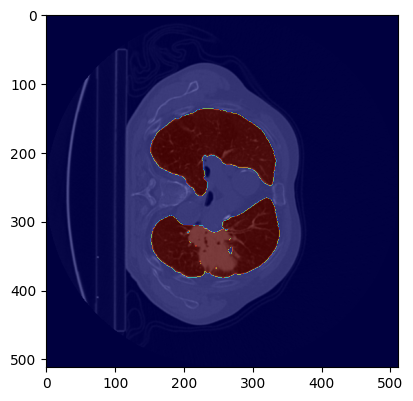

In [13]:
import matplotlib.pyplot as plt
ct = nib.load(r"D:\nsclc\data\nnUNet_raw\Dataset003_Lung\imagesTr\LUNG1-001_0000.nii.gz")
seg = nib.load(r"D:\nsclc\data\nnUNet_raw\Dataset003_Lung\labelsTr\LUNG1-001.nii.gz")
ct_data = ct.get_fdata()
seg_data = seg.get_fdata()


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
slider = 80
plt.imshow(ct_data[:,:,slider], cmap="gray")
plt.imshow(seg_data[:,:,slider], cmap="jet", alpha=0.5)
